# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

## How to Run the Notebook

1. **Open the notebook** `40_COMP90042_Project_2025.ipynb` in Jupyter Notebook, JupyterLab, or any IDE that supports Jupyter (e.g., Google Colab, VSCode).

2. **Load the required data files** (claims and evidence datasets).  
   Make sure the dataset files are placed in the correct directory as expected by the notebook.  
   If the notebook expects specific filenames or paths, update them accordingly in the data loading cells.

3. **Run all cells sequentially from top to bottom.**  
   You can do this via:
   - `Cell` → `Run All` in Jupyter Notebook
   - `Run` → `Run All Cells` in VSCode

4. **Checkpoint saving and result output will happen automatically.**  
   Ensure that no cells are skipped or re-ordered.

5. **Training & Inference:**
   - Training may take several minutes depending on your hardware.
   - Final classification predictions and metrics (accuracy, precision, recall, F1) are printed at the end.


In [ ]:
!pip install faiss-cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# Import necessary libraries
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from tqdm.notebook import tqdm
from itertools import islice
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModel
from torch.optim import AdamW
import faiss
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import nltk
import string
import re
import random
import time

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

##Load data
json -> dict

In [ ]:
train_c = json.load(open('/kaggle/input/nlp-a3/train-claims.json',))
dev_c = json.load(open('/kaggle/input/nlp-a3/dev-claims.json',))
evidence = json.load(open('/kaggle/input/nlp-a3/evidence.json',))

In [ ]:
# Filter out duplicate evidence
evidence_set = set()
temp = {}
for k, v in evidence.items():
    if v not in evidence_set:
        temp[k] = v
        evidence_set.add(v)

evidence = temp

## Text Preprocessing

In [ ]:
def preprocess_text(text):
    """
    Parameters:
    text: The raw text string

    Returns:
    Preprocessed text as a single string with cleaned, lemmatized tokens joined by spaces
    """
    # lower case
    text = text.lower()

    #remove number and punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # tokenize
    tokens = word_tokenize(text)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens_without_stopwords = []
    for token in tokens:
        if token not in stop_words:
            tokens_without_stopwords.append(token)

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens_without_stopwords:
        lemma_tokens.append(lemmatizer.lemmatize(token))

    # Join tokens back to string
    return ' '.join(lemma_tokens)

## Claim Evidence pair into df

In [ ]:
def claim_evidence_pairs(claims_dict, evidence_dict):
    """
    Parameters:
    claims_dict: Dictionary containing claim information

    evidence_dict: Dictionary mapping evidence IDs to the evidence text.

    Returns:
    pandas.DataFrame: A DataFrame where each row represents a claim-evidence pair:
        - claim_id
        - evidence_id
        - claim_text
        - p_claim_text: Preprocessed text of the claim
        - evidence_text
        - p_evidence_text: Preprocessed text of the evidence
        - label
    """
    pairs = []

    for c_ID, c_info in claims_dict.items():
        claim_id = c_ID
        claim_text = c_info['claim_text']
        claim_label = c_info['claim_label']

        for evidence_id in c_info['evidences']:
            evidence_text = evidence[evidence_id]

            pair = {'claim_id': claim_id,
                'evidence_id': evidence_id,
                'claim_text': claim_text,
                'p_claim_text': preprocess_text(claim_text),
                'evidence_text': evidence_text,
                'p_evidence_text': preprocess_text(evidence_text),
                'label': claim_label
                }
            pairs.append(pair)

    return pd.DataFrame(pairs)
df = claim_evidence_pairs(train_c, evidence)
dev_pair = claim_evidence_pairs(dev_c, evidence)
print(df.head(5))
print(dev_pair.head(5))

     claim_id       evidence_id  \
0  claim-1937   evidence-442946   
1  claim-1937  evidence-1194317   
2  claim-1937    evidence-12171   
3   claim-126   evidence-338219   
4   claim-126  evidence-1127398   

                                          claim_text  \
0  Not only is there no scientific evidence that ...   
1  Not only is there no scientific evidence that ...   
2  Not only is there no scientific evidence that ...   
3  El Niño drove record highs in global temperatu...   
4  El Niño drove record highs in global temperatu...   

                                        p_claim_text  \
0  scientific evidence co pollutant higher co con...   
1  scientific evidence co pollutant higher co con...   
2  scientific evidence co pollutant higher co con...   
3  el niño drove record high global temperature s...   
4  el niño drove record high global temperature s...   

                                       evidence_text  \
0  At very high concentrations (100 times atmosph...   
1  

## embeddings

In [ ]:
def text_to_sequence(text, vocab, max_length):
    """
    Parameters:
    text: The text to convert into a numerical sequence.

    vocab: Dictionary mapping words to their numerical indices

    max_length: Maximum sequence length for the evidence text

    Returns:
    sequence: List of integers representing the text, where each integer corresponds
        to a word's index in the vocabulary
    """
    words = text.split()
    sequence = [vocab.get(word, vocab['<UNK>']) for word in words[:max_length]]
    # Pad sequence if needed
    if len(sequence) < max_length:
        sequence += [vocab['<PAD>']] * (max_length - len(sequence))
    return sequence

## Construct dataset to fine-tune evidence retrival model

In [ ]:
# Function to construct a fine-tuning dataset containing (claim_evidence_pair, label)
def fine_tune_dataset(c_dict, evidence, preprocessed):
    """
    Parameters:
    c_dict: Dictionary containing claim information

    evidence: Dictionary mapping evidence IDs to the evidence text.

    preprocessed: Flag indicating whether to preprocess the text data

    Returns:
    claim_evidence_pairs : List of tuples, each tuple contains (claim_text, evidence_text) pairs.

    label_ids: List of numerical labels corresponding to claim-evidence pair
    """
    claim_id = []
    claims = []

    for k, v in c_dict.items():
        claim_id.append(k)
        claims.append(v)

    claim_evidence_pairs = []  # Pairs of claim and evidence texts
    label_ids = []             # Corresponding label IDs

    label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'DISPUTED': 2, 'NOT_ENOUGH_INFO': 3}

    # Iterate through each claim to create claim-evidence pairs and their labels
    for claim in claims:
        for eid in claim['evidences']:
            # Preprocess claim and evidence texts if required
            claim_text = preprocess_text(claim['claim_text']) if preprocessed else claim['claim_text']
            evidence_text = preprocess_text(evidence[eid]) if preprocessed else evidence[eid]

            claim_evidence_pairs.append((claim_text, evidence_text))
            label_ids.append(label_map[claim['claim_label']])

    return claim_evidence_pairs, label_ids

# Generate dataset without preprocessing
claim_evidence_pairs, label_ids = fine_tune_dataset(train_c, evidence, False)

# Generate dataset with preprocessing
pre_claim_evidence_pairs, _ = fine_tune_dataset(train_c, evidence, True)

In [ ]:
# Define a Dataset class for handling claim-evidence pairs and labels
class ClaimEvidenceDataset(Dataset):
    def __init__(self, claim_evidence_pairs, labels, tokenizer):
        self.pairs = claim_evidence_pairs
        self.labels = labels
        self.tokenizer = tokenizer        # Tokenizer for converting raw text into token IDs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        claim, evidence = self.pairs[idx]

        # Tokenize the claim and evidence texts, with padding and truncation
        inputs = self.tokenizer(claim, evidence, truncation=True, padding='max_length', max_length=256, return_tensors="pt")

        # Return the tokenized inputs and the corresponding label as a dictionary
        return {
            'input_ids': inputs['input_ids'].squeeze(0),             # Token IDs for the input text
            'attention_mask': inputs['attention_mask'].squeeze(0),   # Attention mask to ignore padding tokens
            'label': torch.tensor(self.labels[idx])                  # The label
        }

In [ ]:
# Define the model architecture
class ClaimClassifier(nn.Module):
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2", num_classes=4):
        super().__init__()
        # Load a pre-trained model to use as the encoder
        self.encoder = AutoModel.from_pretrained(model_name)

        # Add a classifier head
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = output.last_hidden_state[:, 0, :]  # [CLS] token's embedding

        # Pass the embeddings of [CLS] to the classifier to get predictions
        return self.classifier(cls_token)

In [ ]:
# Instantiate the model
model = ClaimClassifier()

# Load the tokenizer associated with the pre-trained model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# !!! Replace 'claim_evidence_pairs' and 'label_ids' here for different experiments !!!!!!!!!!!!!!!!!!!!!!!!!!!!
train_dataset = ClaimEvidenceDataset(pre_claim_evidence_pairs, label_ids, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Set the model to training mode
model.train()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Train for 5 epochs
for epoch in range(5):
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} loss: {loss.item():.4f}")

Epoch 0 loss: 1.0209
Epoch 1 loss: 0.7505
Epoch 2 loss: 0.6384
Epoch 3 loss: 0.5213
Epoch 4 loss: 0.3973


In [ ]:
# Extract claim and evidence embeddings
def extract_embeddings(texts, original_dict, model=model):
    """
    Parameters:
    texts: List of text strings to extract embedding

    original_dict: Dictionary whose keys will be used to map the extracted embeddings to the original text

    model: Pre-trained transformer model with an encoder component

    Returns:
    embedding_dict: Dictionary mapping keys from original_dict to their corresponding text embeddings
    """
    tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.encoder.to(device)
    model.encoder.eval()      # Set the encoder to evaluation mode

    batch_size = 64
    embedding_dict = {}

    # Setup tqdm progress bar
    num_batches = (len(texts) + batch_size - 1) // batch_size
    with torch.no_grad(), tqdm(total=num_batches, desc="Extracting embeddings") as pbar:
        for start_idx in range(0, len(texts), batch_size):
            batch = texts[start_idx:start_idx + batch_size]
            encodings = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
            outputs = model.encoder(**encodings)
            cls_emb = outputs.last_hidden_state[:, 0, :]  # [CLS] token

            # Assign embeddings to dictionary with index keys
            original_keys = list(original_dict.keys())
            for i, emb in enumerate(cls_emb.cpu()):
                embedding_dict[original_keys[start_idx + i]] = emb

            pbar.update(1)

    return embedding_dict

# 2.Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
# Parameters
MAX_LENGTH = 128
EPOCHS = 10
TOP_K_EVIDENCE = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

Using device: cuda


## Evidence retrieval model

In [ ]:
# Function to normalize embeddings
def normalize_embeddings(embeddings):
    """
    Parameters:
    embeddings: Collection of embedding vectors to normalize

    Returns:
    torch.Tensor:A tensor containing all normalized embeddings
    """
    embeddings_tensor = torch.stack(list(embeddings))

    # Normalize each embedding vector to unit length using L2 norm
    return embeddings_tensor / embeddings_tensor.norm(dim=1, keepdim=True)


# Function to retrieve top-k most similar evidence items for each claim using FAISS
def retrieve_evidence_faiss(evidence_embeddings, dev_claim_embeddings_dict):
    """
    Parameters:
    evidence_embeddings: Dictionary mapping evidence IDs to the embedding vectors.

    dev_claim_embeddings_dict: Dictionary mapping claim IDs to the embedding vectors.

    Returns:
    dct: Dictionary where key is claim ID and value is a dictionary containing:
        1. 'claim_text': The claim text
        2. 'evidences': List of evidence IDs that are most relevant to the claim
    """
    evidence_id = list(evidence.keys())
    # Normalize evidence embeddings
    evidence_embeddings = normalize_embeddings(evidence_embeddings.values()).cpu().numpy().astype('float32')  # shape: [num_evidence, 384]

    lst = list(dev_c.values())
    # Normalize claim embeddings
    claim_embeddings = normalize_embeddings(dev_claim_embeddings_dict.values()).cpu().numpy().astype('float32')  # shape: [num_claims, 384]

    # Build FAISS index using inner product, which equals to cosine similarity here since the vectors are normalized
    index = faiss.IndexFlatIP(evidence_embeddings.shape[1])
    index.add(evidence_embeddings)  # Add evidence vectors to the index

    k = 10 # Search for top 5 most similar evidence for each claim
    D, I = index.search(claim_embeddings, k)  # D: similarity scores, I: indices of top-k evidences

    dct = {} # Mapping of claim IDs to their retrieved evidences
    for i, (indices, scores) in enumerate(zip(I, D)):
        real_claim_id = list(dev_c.keys())[i]
        dct[real_claim_id] = {}

        # Always include the top (most similar) evidence
        prev = scores[0]
        dct[real_claim_id] = {
            'claim_text': dev_c[real_claim_id]['claim_text'],
            'evidences': []
        }
        first_ev_id = evidence_id[indices[0]]
        dct[real_claim_id]['evidences'].append(first_ev_id)

        # Only include other evidence among the top 5 if the similarity score is within 0.05 of the previous one
        for ev_idx, score in zip(indices[1:], scores[1:]):
            if (prev - score) < 0.05:
                prev = score
                ev_id = evidence_id[ev_idx]
                dct[real_claim_id]['evidences'].append(ev_id)
    return dct


## Classification Model

In [ ]:
def train_classification_model(model, dataloader, optimizer, device, epochs=5):
    """
    Parameters:
    model: The transformer-based classification model

    dataloader: DataLoader containing batched training data

    optimizer: The optimizer used for updating model parameters

    device: The computation device to use for training

    epochs: Number of training epochs to run (Default is 5)

    Returns:
    model: The trained model after completing all epochs
    """
    model.train()
    # criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f'Classification Training Epoch {epoch+1}/{epochs}'):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Epoch: {epoch+1}, Loss: {epoch_loss / len(dataloader):.4f}')

    return model

In [ ]:
from torch.utils.data import Subset

# preprocess classifier
label2id = {"SUPPORTS": 0, "REFUTES": 1, "NOT_ENOUGH_INFO": 2, "DISPUTED": 3}
id2label = {v: k for k, v in label2id.items()}

# === Tokenizer ===
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# === Dataset Class ===
class ClaimEvidenceDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoding = self.tokenizer(
            item["p_claim_text"],
            item["p_evidence_text"],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label2id[item["label"]])
        }

records = df.to_dict(orient="records")

support = [ex for ex in records if ex["label"] == "SUPPORTS"]
refutes = [ex for ex in records if ex["label"] == "REFUTES"]
nei = [ex for ex in records if ex["label"] == "NOT_ENOUGH_INFO"]
disputed = [ex for ex in records if ex["label"] == "DISPUTED"]

min_len = min(len(support), len(refutes), len(nei), len(disputed))

balanced_records = (
    resample(support, n_samples=min_len, random_state=42) +
    resample(refutes, n_samples=min_len, random_state=42) +
    resample(nei, n_samples=min_len, random_state=42) +
    resample(disputed, n_samples=min_len, random_state=42)
)

random.shuffle(balanced_records)

full_dataset = ClaimEvidenceDataset(balanced_records, tokenizer)

label_list = [label2id[rec["label"]] for rec in balanced_records]

# === Split data ===
train_idx, val_idx = train_test_split(
    range(len(balanced_records)),
    test_size=0.1,
    stratify=label_list,
    random_state=42,
)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

# === Create loaders ===
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# === Load model ===
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4,
    id2label=id2label,
    label2id=label2id
).to("cuda" if torch.cuda.is_available() else "cpu")

# === Optimizer ===
optimizer = AdamW(model.parameters(), lr=2e-5)

# Actual classifier training
print("Training classification model...")
classification_model = train_classification_model(
    model,
    train_loader,
    optimizer,
    DEVICE,
    epochs=EPOCHS
)

# Save models
torch.save(classification_model.state_dict(), 'classification_model.pt')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training classification model...


Classification Training Epoch 1/10:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch: 1, Loss: 1.3691


Classification Training Epoch 2/10:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch: 2, Loss: 1.0766


Classification Training Epoch 3/10:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.5074


Classification Training Epoch 4/10:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.2084


Classification Training Epoch 5/10:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.0969


Classification Training Epoch 6/10:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.0618


Classification Training Epoch 7/10:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.0390


Classification Training Epoch 8/10:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.0594


Classification Training Epoch 9/10:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.0419


Classification Training Epoch 10/10:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.0230


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
class RetrievedEvidenceDataset(Dataset):
    def __init__(self, retrieved_claims, evidence_dict, tokenizer, label2id, max_length=256):
        self.entries = []
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length

        for claim_id, content in retrieved_claims.items():
            claim_text = content["claim_text"]
            evidence_ids = content.get("evidences", [])
            evidence_texts = [evidence_dict[eid] for eid in evidence_ids if eid in evidence_dict]
            combined_evidence = " ".join(evidence_texts)
            self.entries.append({
                "claim": claim_text,
                "evidence": combined_evidence
            })

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        item = self.entries[idx]
        encoding = self.tokenizer(
            item['claim'],
            item['evidence'],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

In [ ]:
def fact_check_pipeline(
    evidence_corpus,
    classification_model,
    evidence_embeddings,
    dev_claim_embeddings_dict,
    max_length,
    top_k=10,
    device='cpu'
    ):
    """
    Parameters:
    evidence_corpus: Dictionary mapping evidence IDs to their corresponding text content

    classification_model: The trained model for classifying claim-evidence pairs

    evidence_embeddings: Dictionary mapping evidence IDs to their embedding

    dev_claim_embeddings_dict: Dictionary mapping claim IDs to their embedding

    max_length:  Maximum sequence length for tokenization

    top_k: Number of top evidence pieces to retrieve per claim (Default is 5)

    device: The computation device (Default is 'cpu')

    Returns:
    results: Dictionary where key is claim ID and value is a dictionary containing:
        - 'claim_text': The original text of the claim
        - 'claim_label': The predicted veracity label for the claim
        - 'evidences': List of evidence IDs that were used for verification

        (Also saved as a JSON file named "final_predictions.json")
    """
    results = {}

    # Retrieve the related evidence for each claim
    claim_retrieved_evidence_dict = retrieve_evidence_faiss(evidence_embeddings, dev_claim_embeddings_dict)

    dataset = RetrievedEvidenceDataset(claim_retrieved_evidence_dict, evidence_corpus, tokenizer, label2id)
    loader = DataLoader(dataset, batch_size=16)

    predictions = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = classification_model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).tolist()

            predictions.extend(preds)

    # Add predictions back to original claim structure
    results = {}
    for (claim_id, content), pred in zip(claim_retrieved_evidence_dict.items(), predictions):
        results[claim_id] = {
            "claim_text": content["claim_text"],
            "claim_label": id2label[pred],
            "evidences": content["evidences"]
        }

    # Save predictions
    with open("final_predictions.json", "w") as f:
        json.dump(results, f, indent=2)

    return results

In [ ]:
def evaluate_f_score(predictions, groundtruth):
    """
    Parameters:
    predictions: Dictionary containing prediction results

    groundtruth: Dictionary containing ground truth data

    Returns:
    evidence_retrieval_f: The average F1 score for evidence retrieval across all claims
    """
    evidence_f_scores = []
    correct_classifications = 0
    total_claims = 0

    for claim_id in groundtruth:
        if claim_id not in predictions:
            continue

        total_claims += 1

        # Evidence retrieval evaluation
        pred_evidences = set(predictions[claim_id]["evidences"])
        gt_evidences = set(groundtruth[claim_id]["evidences"])

        # Calculate precision, recall, and F-score
        if len(pred_evidences) == 0:
            precision = 0
        else:
            precision = len(pred_evidences.intersection(gt_evidences)) / len(pred_evidences)

        if len(gt_evidences) == 0:
            recall = 1 if len(pred_evidences) == 0 else 0
        else:
            recall = len(pred_evidences.intersection(gt_evidences)) / len(gt_evidences)

        if precision + recall == 0:
            f_score = 0
        else:
            f_score = 2 * precision * recall / (precision + recall)

        evidence_f_scores.append(f_score)

        # Classification evaluation
        if predictions[claim_id]["claim_label"] == groundtruth[claim_id]["claim_label"]:
            correct_classifications += 1

    # Calculate aggregate metrics
    evidence_retrieval_f = sum(evidence_f_scores) / total_claims

    return evidence_retrieval_f

In [ ]:
# raw text
evidence_embeddings_dict = extract_embeddings(list(evidence.values()), evidence)
dev_claim_embeddings_dict = extract_embeddings([i['claim_text'] for i in dev_c.values()], dev_c)

Extracting embeddings:   0%|          | 0/18654 [00:00<?, ?it/s]

Extracting embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Run the fact-checking pipeline on dev data
dev_results = fact_check_pipeline(
    evidence,
    classification_model,
    evidence_embeddings_dict,
    dev_claim_embeddings_dict,
    MAX_LENGTH,
    top_k=TOP_K_EVIDENCE,
    device=DEVICE
)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

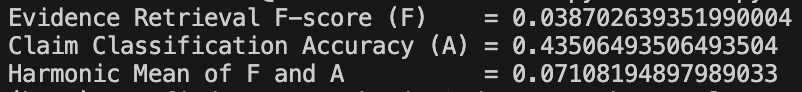

Classification Report
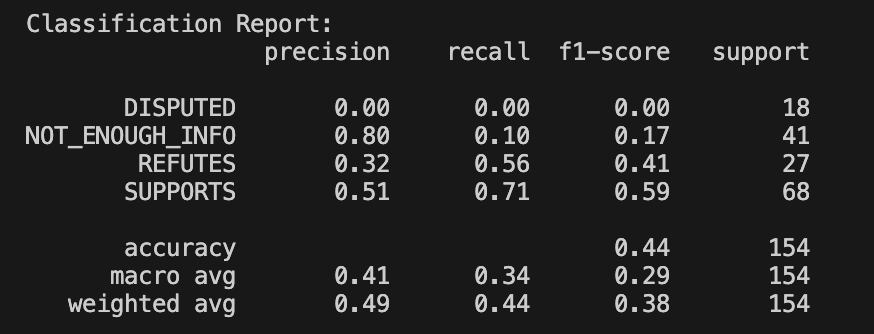

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*